In [1]:
from __future__ import print_function

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
import seaborn as sns
from ipywidgets import fixed, interact, interact_manual, interactive
from natsort import index_natsorted
from scipy.stats import norm

%load_ext line_profiler
%matplotlib inline
pyo.init_notebook_mode(connected=True)

In [2]:
df = pd.read_csv("../../data/3_analysis-resistance/all_rgiout_2022-12-01", sep="\t")
df = df.sort_values(
    by=["Accession_Number"],
    ascending=True,
    key=lambda x: np.argsort(index_natsorted(df["Accession_Number"])),
    ignore_index=True,
)
df[["Species", "Subspecies"]] = df["Strain"].str.split("subsp.", 1, expand=True)
df = df.replace(np.nan, "Null", regex=True)
df["Contig"] = df["Contig"].str.split("_", expand=True)[0]
# df['Start'] = df['Start'].astype(int)
# df['Stop'] = df['Stop'].astype(int)
single_acc_df = df.drop_duplicates(subset=["Accession_Number"])
year_dict = (
    single_acc_df[["Accession_Number", "Year_Cultured"]]
    .set_index("Accession_Number")
    .to_dict()["Year_Cultured"]
)

In [3]:
full_nctcdf = pd.read_csv("../../data/0_databases/nctc_db.csv", sep="\t", index_col=0)
full_nctcdf = full_nctcdf.sort_values(
    by=["NCTC_Number"],
    ascending=True,
    key=lambda x: np.argsort(index_natsorted(full_nctcdf["NCTC_Number"])),
    ignore_index=True,
)
full_nctcdf[["Species", "Subspecies"]] = full_nctcdf["Current_Name"].str.split(
    "subsp.", 1, expand=True
)
full_nctcdf = full_nctcdf.replace(np.nan, "Null", regex=True)
genomeandyear_nctcdf = full_nctcdf.loc[
    (full_nctcdf["Year_Cultured"] != -1)
    & (full_nctcdf["Assembly_Accessions"] != "Null")
].copy()
family_name = genomeandyear_nctcdf["Species"].str.split(" ", expand=True)[0].str[0]
species_name = genomeandyear_nctcdf["Species"].str.split(" ", expand=True)[1]
genomeandyear_nctcdf["Specie_Name"] = family_name + ". " + species_name
specie_counts = genomeandyear_nctcdf["Specie_Name"].value_counts()
topx = specie_counts.head(5).index.tolist()
genomeandyear_nctcdf["TopSpecies"] = genomeandyear_nctcdf["Specie_Name"]
genomeandyear_nctcdf.loc[
    ~genomeandyear_nctcdf["TopSpecies"].isin(topx), ["TopSpecies"]
] = "Other"
genomeandyear_nctcdf["Accession_Number"] = genomeandyear_nctcdf[
    "NCTC_Number"
].str.replace(" ", "")
specie_dict = (
    genomeandyear_nctcdf[["Accession_Number", "Specie_Name"]]
    .set_index("Accession_Number")
    .to_dict()["Specie_Name"]
)

In [4]:
df["Species_Name"] = df["Accession_Number"].map(specie_dict)
df["Species_Name"].value_counts().head(5).index

Index(['E. coli', 'S. enterica', 'K. pneumoniae', 'P. aeruginosa',
       'S. aureus'],
      dtype='object')

In [5]:
mamodf_resistance = pd.read_csv(
    "../../data/3_analysis-mamo/mergedmamooutput",
    sep="\t",
    names=[
        "Accession_Number",
        "Contig",
        "Start",
        "Stop",
        "AbG",
        "mobileelementfinder",
        "IntegronFinder",
        "PlasmidFinder",
        "mob_recon",
    ],
)
mamodf_resistance["Start"] = mamodf_resistance["Start"].astype("object")
mamodf_resistance["Stop"] = mamodf_resistance["Stop"].astype("object")

In [6]:
merged_rgi_mamo = df.merge(
    mamodf_resistance,
    on=["Accession_Number", "Contig", "Start", "Stop"],
    how="outer",
    indicator=True,
)
merged_rgi_mamo["_merge"].value_counts()

both          31071
left_only       432
right_only        0
Name: _merge, dtype: int64

In [7]:
import seaborn as sns

# Create a new dataframe with only the columns of interest
mobility_df = merged_rgi_mamo[merged_rgi_mamo["_merge"] == "both"][
    [
        "Accession_Number",
        "Species_Name",
        "Best_Hit_ARO",
        "Resistance Mechanism",
        "AMR Gene Family",
        "Drug Class",
        "Year_Cultured",
        "mobileelementfinder",
        "IntegronFinder",
        "PlasmidFinder",
        "mob_recon",
    ]
].copy()

# Create a new column 'Mobile' with default value 1
mobility_df["Mobile"] = 1

# Set 'Mobile' to 0 for rows where all four columns are equal to specific values
mobility_df.loc[
    (mobility_df["mobileelementfinder"] == "no-me")
    & (mobility_df["IntegronFinder"] == "no-integron")
    & (mobility_df["PlasmidFinder"] == "no-plasmid")
    & (mobility_df["mob_recon"] == "no-plasmid"),
    "Mobile",
] = 0

mobility_df["me_simp"] = "no-me"
mobility_df.loc[
    mobility_df["mobileelementfinder"] != "no-me", "me_simp"
] = "mobileelement"

# mobility_df
# mobility_df[mobility_df["Mobile"] == 1][['Best_Hit_ARO','Mobile']].value_counts()

In [8]:
mobility_df["integron_simp"] = "no-integron"
mobility_df.loc[
    (mobility_df["IntegronFinder"] == "CALIN")
    | (mobility_df["IntegronFinder"] == "complete"),
    "integron_simp",
] = "Integron-associated"

mobility_df["plasmid_simp"] = "no-plasmid"
mobility_df.loc[
    (mobility_df["mob_recon"] != "no-plasmid"),
    "plasmid_simp",
] = "Plasmid-associated"

mobility_df["plasmidtype_simp"] = "no-plasmid"
mobility_df.loc[
    mobility_df["mob_recon"].str.contains("conjugative"),
    "plasmidtype_simp",
] = "conjugative"
mobility_df.loc[
    mobility_df["mob_recon"].str.contains("mobilizable"),
    "plasmidtype_simp",
] = "mobilizable"
mobility_df.loc[
    mobility_df["mob_recon"].str.contains("non-mobilizable"),
    "plasmidtype_simp",
] = "non-mobilizable"

mobility_df["Mobile"] = mobility_df.apply(
    lambda x: "{}|{}|{}".format(x["me_simp"], x["integron_simp"], x["plasmid_simp"]),
    axis=1,
)
# mobility_df

In [9]:
mobility_df

,Accession_Number,Species_Name,Best_Hit_ARO,Resistance Mechanism,AMR Gene Family,Drug Class,Year_Cultured,mobileelementfinder,IntegronFinder,PlasmidFinder,mob_recon,Mobile,me_simp,integron_simp,plasmid_simp,plasmidtype_simp
0,NCTC1,S. flexneri,vanG,antibiotic target alteration,glycopeptide resistance gene cluster; Van ligase,glycopeptide antibiotic,1914,nested-cn_13315_ISSfl10;cn_30892_ISEc27;cn_308...,no-integron,no-plasmid,no-plasmid,mobileelement|no-integron|no-plasmid,mobileelement,no-integron,no-plasmid,no-plasmid
1,NCTC1,S. flexneri,acrB,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,fluoroquinolone antibiotic; cephalosporin; gly...,1914,no-me,no-integron,no-plasmid,no-plasmid,no-me|no-integron|no-plasmid,no-me,no-integron,no-plasmid,no-plasmid
2,NCTC1,S. flexneri,Escherichia coli acrA,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,fluoroquinolone antibiotic; cephalosporin; gly...,1914,no-me,no-integron,no-plasmid,no-plasmid,no-me|no-integron|no-plasmid,no-me,no-integron,no-plasmid,no-plasmid
3,NCTC1,S. flexneri,msbA,antibiotic efflux,ATP-binding cassette (ABC) antibiotic efflux pump,nitroimidazole antibiotic,1914,nested-cn_23569_IS4,no-integron,no-plasmid,no-plasmid,mobileelement|no-integron|no-plasmid,mobileelement,no-integron,no-plasmid,no-plasmid
4,NCTC1,S. flexneri,mdtH,antibiotic efflux,major facilitator superfamily (MFS) antibiotic...,fluoroquinolone antibiotic,1914,no-me,no-integron,no-plasmid,no-plasmid,no-me|no-integron|no-plasmid,no-me,no-integron,no-plasmid,no-plasmid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31498,NCTC14382,Y. canariae,evgA,antibiotic efflux,major facilitator superfamily (MFS) antibiotic...,macrolide antibiotic; fluoroquinolone antibiot...,2018,no-me,no-integron,no-plasmid,no-plasmid,no-me|no-integron|no-plasmid,no-me,no-integron,no-plasmid,no-plasmid
31499,NCTC14382,Y. canariae,CRP,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,macrolide antibiotic; fluoroquinolone antibiot...,2018,no-me,no-integron,no-plasmid,no-plasmid,no-me|no-integron|no-plasmid,no-me,no-integron,no-plasmid,no-plasmid
31500,NCTC14382,Y. canariae,Haemophilus influenzae PBP3 conferring resista...,antibiotic target alteration,Penicillin-binding protein mutations conferrin...,cephalosporin; cephamycin; penam,2018,no-me,no-integron,no-plasmid,no-plasmid,no-me|no-integron|no-plasmid,no-me,no-integron,no-plasmid,no-plasmid
31501,NCTC14382,Y. canariae,Escherichia coli EF-Tu mutants conferring resi...,antibiotic target alteration,elfamycin resistant EF-Tu,elfamycin antibiotic,2018,no-me,no-integron,no-plasmid,no-plasmid,no-me|no-integron|no-plasmid,no-me,no-integron,no-plasmid,no-plasmid


In [10]:
import scipy.stats as stats
import statsmodels.stats.proportion as prop

def calculate_frequency_bounds(row, confidence=0.95):
    successes = row['count']
    attempts = row['total_count']
    alpha = successes + 1
    beta = attempts - successes + 1
    return(stats.beta.interval(confidence, alpha, beta))

print(prop.proportion_confint(20, 20))
# print(prop.proportion_confint(5, 10))
# print(prop.proportion_confint(1, 20))
# print(prop.proportion_confint(5, 100))
print(prop.proportion_confint(20, 20, method='agresti_coull'))
# print(prop.proportion_confint(5, 10, method='agresti_coull'))
# print(prop.proportion_confint(1, 20, method='agresti_coull'))
# print(prop.proportion_confint(5, 100, method='agresti_coull'))
print(prop.proportion_confint(20, 20, method='beta'))
# print(prop.proportion_confint(5, 10, method='beta'))
# print(prop.proportion_confint(1, 20, method='beta'))
# print(prop.proportion_confint(5, 100, method='beta'))
print(prop.proportion_confint(20, 20, method='jeffreys'))
# print(prop.proportion_confint(5, 10, method='jeffreys'))
# print(prop.proportion_confint(1, 20, method='jeffreys'))
# print(prop.proportion_confint(5, 100, method='jeffreys'))

(1.0, 1.0)
(0.810190439457511, 1.0)
(0.8315665290169146, 1.0)
(0.8833610170951246, 0.9999757535215408)


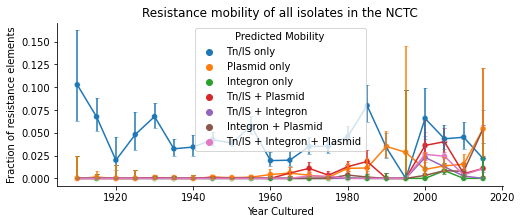

In [56]:
import pandas as pd
import seaborn as sns

# Bin the 'Year_Cultured' column by 5-year intervals
mobility_df["Year_Cultured_Binned"] = pd.cut(
    mobility_df["Year_Cultured"], bins=range(1910, 2025, 5), labels=range(1910, 2020, 5)
)

# filtered_df = mobility_df[mobility_df['Mobile'] != 'no-me|no-integron|no-plasmid']

# Group the dataframe by 'Year_Cultured_Binned' and 'Mobile' columns, and count the number of occurrences of each 'Mobile' class per year
grouped_df = (
    mobility_df.groupby(["Year_Cultured_Binned", "Mobile"])
    .size()
    .reset_index(name="count")
)

# Calculate the total count of resistance elements per year
year_counts = (
    grouped_df.groupby("Year_Cultured_Binned")["count"]
    .sum()
    .reset_index(name="total_count")
)

# Merge the grouped dataframe with the year_counts dataframe to compute the fraction of resistance elements of each 'Mobile' class over time
merged_df = pd.merge(grouped_df, year_counts, on="Year_Cultured_Binned")
merged_df["fraction"] = merged_df["count"] / merged_df["total_count"]

plt.figure(figsize=(12, 6))

merged_df.loc[
    merged_df["Mobile"] == "no-me|no-integron|Plasmid-associated", "Mobile"
] = "Plasmid only"
merged_df.loc[
    merged_df["Mobile"] == "no-me|Integron-associated|no-plasmid", "Mobile"
] = "Integron only"
merged_df.loc[
    merged_df["Mobile"] == "no-me|Integron-associated|Plasmid-associated", "Mobile"
] = "Integron + Plasmid"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|Integron-associated|Plasmid-associated",
    "Mobile",
] = "Tn/IS + Integron + Plasmid"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|no-integron|Plasmid-associated", "Mobile"
] = "Tn/IS + Plasmid"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|Integron-associated|no-plasmid", "Mobile"
] = "Tn/IS + Integron"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|no-integron|no-plasmid", "Mobile"
] = "Tn/IS only"
# print(merged_df)
merged_df[['lower-error', 'upper-error']] = merged_df.apply(calculate_frequency_bounds, axis=1, result_type='expand')

filtered_df = (
    merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"]
    .reset_index()
    .copy()
)


# Plot the results using a pointplot in Seaborn
ax = sns.scatterplot(
    x="Year_Cultured_Binned",
    y="fraction",
    hue="Mobile",
    data=filtered_df,
    hue_order=[
        "Tn/IS only",
        "Plasmid only",
        "Integron only",
        "Tn/IS + Plasmid",
        "Tn/IS + Integron",
        "Integron + Plasmid",
        "Tn/IS + Integron + Plasmid",
    ],
)

legend_handles, legend_labels = ax.get_legend_handles_labels()
hue_colors = {
    label: handle.get_facecolor()
    for handle, label in zip(legend_handles, legend_labels)
}
# print(hue_colors)

sns.lineplot(
    x="Year_Cultured_Binned",
    y="fraction",
    hue="Mobile",
    data=filtered_df,
    hue_order=[
        "Tn/IS only",
        "Plasmid only",
        "Integron only",
        "Tn/IS + Plasmid",
        "Tn/IS + Integron",
        "Integron + Plasmid",
        "Tn/IS + Integron + Plasmid",
    ],
    legend=False
)

# ax.set(ylim=(-0.005, max(filtered_df["fraction"] * 1.5)))
ax.legend(title="Predicted Mobility")
ax.set(
    xlabel="Year Cultured",
    ylabel="Fraction of resistance elements",
    title="Resistance mobility of all isolates in the NCTC",
)
sns.despine()

# Add error bars using matplotlib
for i in range(len(filtered_df)):
    x = filtered_df.loc[i, "Year_Cultured_Binned"]
    y = filtered_df.loc[i, "fraction"]
    yerror_low = filtered_df.loc[i, "lower-error"]
    yerror_upper = filtered_df.loc[i, "upper-error"]
    ax.errorbar(
        x,
        y,
        yerr=[[y-yerror_low], [yerror_upper-y]],
        color=hue_colors[filtered_df.loc[i, "Mobile"]],
        alpha=1,
        capsize=2,
        capthick=0.5,
    )

plt.gcf().set_size_inches(8, 3)
plt.savefig(
    "./figs/fig5/fractionmobileresistanceelements-point.svg",
    bbox_inches="tight",
    dpi=300,
)

plt.show()

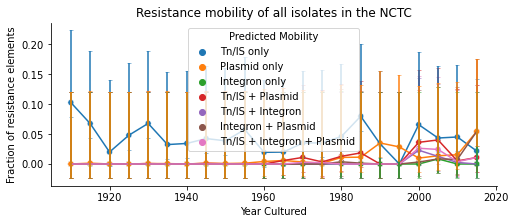

In [62]:
import pandas as pd
import seaborn as sns

# Bin the 'Year_Cultured' column by 5-year intervals
mobility_df["Year_Cultured_Binned"] = pd.cut(
    mobility_df["Year_Cultured"], bins=range(1910, 2025, 5), labels=range(1910, 2020, 5)
)

# filtered_df = mobility_df[mobility_df['Mobile'] != 'no-me|no-integron|no-plasmid']

# Group the dataframe by 'Year_Cultured_Binned' and 'Mobile' columns, and count the number of occurrences of each 'Mobile' class per year
grouped_df = (
    mobility_df.groupby(["Year_Cultured_Binned", "Mobile"])
    .size()
    .reset_index(name="count")
)

# Calculate the total count of resistance elements per year
year_counts = (
    grouped_df.groupby("Year_Cultured_Binned")["count"]
    .sum()
    .reset_index(name="total_count")
)

# Merge the grouped dataframe with the year_counts dataframe to compute the fraction of resistance elements of each 'Mobile' class over time
merged_df = pd.merge(grouped_df, year_counts, on="Year_Cultured_Binned")
merged_df["fraction"] = merged_df["count"] / merged_df["total_count"]

plt.figure(figsize=(12, 6))

merged_df.loc[
    merged_df["Mobile"] == "no-me|no-integron|Plasmid-associated", "Mobile"
] = "Plasmid only"
merged_df.loc[
    merged_df["Mobile"] == "no-me|Integron-associated|no-plasmid", "Mobile"
] = "Integron only"
merged_df.loc[
    merged_df["Mobile"] == "no-me|Integron-associated|Plasmid-associated", "Mobile"
] = "Integron + Plasmid"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|Integron-associated|Plasmid-associated",
    "Mobile",
] = "Tn/IS + Integron + Plasmid"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|no-integron|Plasmid-associated", "Mobile"
] = "Tn/IS + Plasmid"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|Integron-associated|no-plasmid", "Mobile"
] = "Tn/IS + Integron"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|no-integron|no-plasmid", "Mobile"
] = "Tn/IS only"
merged_df[['lower-error', 'upper-error']] = merged_df.apply(calculate_frequency_bounds, axis=1, result_type='expand')

filtered_df = (
    merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"]
    .reset_index()
    .copy()
)


# Plot the results using a pointplot in Seaborn
ax = sns.scatterplot(
    x="Year_Cultured_Binned",
    y="fraction",
    hue="Mobile",
    data=filtered_df,
    # dodge=True,
    # markers="o",
    # linestyles="-",
    hue_order=[
        "Tn/IS only",
        "Plasmid only",
        "Integron only",
        "Tn/IS + Plasmid",
        "Tn/IS + Integron",
        "Integron + Plasmid",
        "Tn/IS + Integron + Plasmid",
    ],
    # errorbar='sd'
    # multiple="stack"
)
legend_handles, legend_labels = ax.get_legend_handles_labels()
hue_colors = {
    label: handle.get_facecolor()
    for handle, label in zip(legend_handles, legend_labels)
}
# print(hue_colors)

sns.lineplot(
    x="Year_Cultured_Binned",
    y="fraction",
    hue="Mobile",
    data=filtered_df,
    # dodge=True,
    # markers="o",
    # linestyles="-",
    hue_order=[
        "Tn/IS only",
        "Plasmid only",
        "Integron only",
        "Tn/IS + Plasmid",
        "Tn/IS + Integron",
        "Integron + Plasmid",
        "Tn/IS + Integron + Plasmid",
    ],
    legend=False
    # errorbar='sd'
    # multiple="stack"
)

# ax.set(ylim=(-0.005, max(filtered_df["fraction"] * 1.5)))
# lp.set(ylim=(0, 1))


ax.legend(title="Predicted Mobility")
ax.set(
    xlabel="Year Cultured",
    ylabel="Fraction of resistance elements",
    title="Resistance mobility of all isolates in the NCTC",
)
# plt.xticks(rotation=45, ha="right")

sns.despine()

# Add error bars using matplotlib
for i in range(len(filtered_df)):
    x = filtered_df.loc[i, "Year_Cultured_Binned"]
    y = filtered_df.loc[i, "fraction"]
    # errord = filtered_df.loc[i, "error"]
    ax.errorbar(
        x,
        y,
        yerr=[[yerror_low], [yerror_upper]],
        color=hue_colors[filtered_df.loc[i, "Mobile"]],
        alpha=1,
        capsize=2,
        capthick=0.5,
    )

plt.gcf().set_size_inches(8, 3)
plt.savefig(
    "./figs/fig5/fractionmobileresistanceelements-point.svg",
    bbox_inches="tight",
    dpi=300,
)

plt.show()

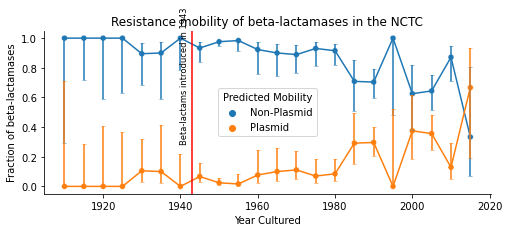

In [65]:
import pandas as pd
import seaborn as sns

# Bin the 'Year_Cultured' column by 5-year intervals
mobility_df["Year_Cultured_Binned"] = pd.cut(
    mobility_df["Year_Cultured"], bins=range(1910, 2025, 5), labels=range(1910, 2020, 5)
)

betalactamase_mobility_df = mobility_df[
    mobility_df["AMR Gene Family"].str.contains("beta-lactamase")
]

# betalactamase_mobility_df = betalactamase_mobility_df[
#     betalactamase_mobility_df["Mobile"] != "no-me|no-integron|no-plasmid"
# ]

betalactamase_mobility_df.loc[
    betalactamase_mobility_df["Mobile"] == "no-me|no-integron|no-plasmid", "Mobile"
] = "Non-Plasmid"
betalactamase_mobility_df.loc[
    betalactamase_mobility_df["Mobile"] == "no-me|no-integron|Plasmid-associated",
    "Mobile",
] = "Plasmid"
betalactamase_mobility_df.loc[
    betalactamase_mobility_df["Mobile"] == "no-me|Integron-associated|no-plasmid",
    "Mobile",
] = "Non-Plasmid"
betalactamase_mobility_df.loc[
    betalactamase_mobility_df["Mobile"]
    == "no-me|Integron-associated|Plasmid-associated",
    "Mobile",
] = "Plasmid"
betalactamase_mobility_df.loc[
    betalactamase_mobility_df["Mobile"]
    == "mobileelement|Integron-associated|Plasmid-associated",
    "Mobile",
] = "Plasmid"
betalactamase_mobility_df.loc[
    betalactamase_mobility_df["Mobile"]
    == "mobileelement|no-integron|Plasmid-associated",
    "Mobile",
] = "Plasmid"
betalactamase_mobility_df.loc[
    betalactamase_mobility_df["Mobile"]
    == "mobileelement|Integron-associated|no-plasmid",
    "Mobile",
] = "Non-Plasmid"
betalactamase_mobility_df.loc[
    betalactamase_mobility_df["Mobile"] == "mobileelement|no-integron|no-plasmid",
    "Mobile",
] = "Non-Plasmid"

# print(betalactamase_mobility_df)

# filtered_df = mobility_df[mobility_df['Mobile'] != 'no-me|no-integron|no-plasmid']

# Group the dataframe by 'Year_Cultured_Binned' and 'Mobile' columns, and count the number of occurrences of each 'Mobile' class per year
grouped_df = (
    betalactamase_mobility_df.groupby(["Year_Cultured_Binned", "Mobile"])
    .size()
    .reset_index(name="count")
)

# Calculate the total count of resistance elements per year
year_counts = (
    grouped_df.groupby("Year_Cultured_Binned")["count"]
    .sum()
    .reset_index(name="total_count")
)

# Merge the grouped dataframe with the year_counts dataframe to compute the fraction of resistance elements of each 'Mobile' class over time
merged_df = pd.merge(grouped_df, year_counts, on="Year_Cultured_Binned")
merged_df["fraction"] = merged_df["count"] / merged_df["total_count"]
merged_df[['lower-error', 'upper-error']] = merged_df.apply(calculate_frequency_bounds, axis=1, result_type='expand')

plt.figure(figsize=(12, 6))

# Plot the results using a barplot in Seaborn
# sns.barplot(
#     x="Year_Cultured_Binned",
#     y="fraction",
#     hue="Mobile",
#     # errorbar='sd',
#     data=merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"],
# )
# xdf["error"] = np.sqrt(xdf["frac"] * (1 - xdf["frac"]) / xdf["all"])
# xdf["se"] = 1.96 * xdf["error"]

filtered_df = (
    merged_df
    # merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"]
    # .reset_index()
    # .copy()
)
# print(merged_df)


# Plot the results using a pointplot in Seaborn
ax = sns.scatterplot(
    x="Year_Cultured_Binned",
    y="fraction",
    hue="Mobile",
    data=filtered_df,
    # dodge=True,
    # markers="o",
    # linestyles="-",
    # hue_order=[
    #     "Tn/IS only",
    #     "Plasmid only",
    #     "Integron only",
    #     "Tn/IS + Plasmid",
    #     "Tn/IS + Integron",
    #     "Integron + Plasmid",
    #     "Tn/IS + Integron + Plasmid",
    # ],
    # errorbar='sd'
    # multiple="stack"
)
legend_handles, legend_labels = ax.get_legend_handles_labels()
hue_colors = {
    label: handle.get_facecolor()
    for handle, label in zip(legend_handles, legend_labels)
}
# print(hue_colors)

sns.lineplot(
    x="Year_Cultured_Binned",
    y="fraction",
    hue="Mobile",
    data=filtered_df,
    # dodge=True,
    # markers="o",
    # linestyles="-",
    # hue_order=[
    #     "Tn/IS only",
    #     "Plasmid only",
    #     "Integron only",
    #     "Tn/IS + Plasmid",
    #     "Tn/IS + Integron",
    #     "Integron + Plasmid",
    #     "Tn/IS + Integron + Plasmid",
    # ],
    legend=False
    # errorbar='sd'
    # multiple="stack"
)

# ax.set(ylim=(-0.005, max(filtered_df["fraction"] * 1.5)))
# ax.set(ylim=(-0.005, 1))

# lp.set(ylim=(0, 1))


ax.legend(title="Predicted Mobility")
ax.set(
    xlabel="Year Cultured",
    ylabel="Fraction of beta-lactamases",
    title="Resistance mobility of beta-lactamases in the NCTC",
)
# plt.xticks(rotation=45, ha="right")

sns.despine()

# Add error bars using matplotlib
for i in range(len(filtered_df)):
    x = filtered_df.loc[i, "Year_Cultured_Binned"]
    y = filtered_df.loc[i, "fraction"]
    yerror_low = filtered_df.loc[i, "lower-error"]
    yerror_upper = filtered_df.loc[i, "upper-error"]
    # plt.fill_between(
    #     x,
    #     yerror_low,
    #     yerror_upper,
    #     alpha=0.3,
    #     edgecolor=hue_colors[filtered_df.loc[i, "Mobile"]],
    #     facecolor=hue_colors[filtered_df.loc[i, "Mobile"]],
    # )
    ax.errorbar(
        x,
        y,
        yerr=[[y-yerror_low], [yerror_upper-y]],
        color=hue_colors[filtered_df.loc[i, "Mobile"]],
        alpha=1,
        capsize=2,
        capthick=0.5,
    )
plt.axvline(1943, color="red", label='Beta-lactamases introduced in {}'.format(1943))
plt.text(
        1943 - 3,
        0.3,
        "Beta-lactams introduced in {}".format(1943),
        rotation=90,
        # transform=trans,
        fontsize="small",
    )

plt.gcf().set_size_inches(8, 3)
plt.savefig(
    "./figs/fig5/betalactamase-fractionmobileresistanceelements.svg",
    bbox_inches="tight",
    dpi=300,
)

plt.show()

In [67]:
np.sqrt(
        merged_df["fraction"] * (1 - merged_df["fraction"]) / merged_df["total_count"]
    )

,Year_Cultured_Binned,Mobile,count,total_count,fraction,error
0,1910,Non-Plasmid,2,2,1.000000,0.000000
1,1910,Plasmid,0,2,0.000000,0.000000
2,1915,Non-Plasmid,10,10,1.000000,0.000000
3,1915,Plasmid,0,10,0.000000,0.000000
4,1920,Non-Plasmid,6,6,1.000000,0.000000
5,1920,Plasmid,0,6,0.000000,0.000000
6,1925,Non-Plasmid,7,7,1.000000,0.000000
7,1925,Plasmid,0,7,0.000000,0.000000
8,1930,Non-Plasmid,17,19,0.894737,0.137996
9,1930,Plasmid,2,19,0.105263,0.137996


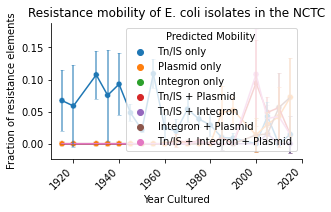

In [10]:
import pandas as pd
import seaborn as sns

ecoli_df = mobility_df[mobility_df["Species_Name"] == "E. coli"].copy()

# Bin the 'Year_Cultured' column by 5-year intervals
ecoli_df["Year_Cultured_Binned"] = pd.cut(
    ecoli_df["Year_Cultured"], bins=range(1910, 2025, 5), labels=range(1910, 2020, 5)
)


# Group the dataframe by 'Year_Cultured_Binned' and 'Mobile' columns, and count the number of occurrences of each 'Mobile' class per year
grouped_df = (
    ecoli_df.groupby(["Year_Cultured_Binned", "Mobile"])
    .size()
    .reset_index(name="count")
)

# Calculate the total count of resistance elements per year
year_counts = (
    grouped_df.groupby("Year_Cultured_Binned")["count"]
    .sum()
    .reset_index(name="total_count")
)

# Merge the grouped dataframe with the year_counts dataframe to compute the fraction of resistance elements of each 'Mobile' class over time
merged_df = pd.merge(grouped_df, year_counts, on="Year_Cultured_Binned")
merged_df["fraction"] = merged_df["count"] / merged_df["total_count"]

plt.figure(figsize=(12, 6))

merged_df.loc[
    merged_df["Mobile"] == "no-me|no-integron|Plasmid-associated", "Mobile"
] = "Plasmid only"
merged_df.loc[
    merged_df["Mobile"] == "no-me|Integron-associated|no-plasmid", "Mobile"
] = "Integron only"
merged_df.loc[
    merged_df["Mobile"] == "no-me|Integron-associated|Plasmid-associated", "Mobile"
] = "Integron + Plasmid"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|Integron-associated|Plasmid-associated",
    "Mobile",
] = "Tn/IS + Integron + Plasmid"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|no-integron|Plasmid-associated", "Mobile"
] = "Tn/IS + Plasmid"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|Integron-associated|no-plasmid", "Mobile"
] = "Tn/IS + Integron"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|no-integron|no-plasmid", "Mobile"
] = "Tn/IS only"

merged_df["error"] = (
    np.sqrt(
        merged_df["fraction"] * (1 - merged_df["fraction"]) / merged_df["total_count"]
    )
    * 1.96
)


# Plot the results using a barplot in Seaborn
# sns.barplot(
#     x="Year_Cultured_Binned",
#     y="fraction",
#     hue="Mobile",
#     # errorbar='sd',
#     data=merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"],
# )
# xdf["error"] = np.sqrt(xdf["frac"] * (1 - xdf["frac"]) / xdf["all"])
# xdf["se"] = 1.96 * xdf["error"]

filtered_df = (
    merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"]
    .reset_index()
    .copy()
)

# Plot the results using a pointplot in Seaborn
ax = sns.scatterplot(
    x="Year_Cultured_Binned",
    y="fraction",
    hue="Mobile",
    data=filtered_df,
    # dodge=True,
    # markers="o",
    # linestyles="-",
    hue_order=[
        "Tn/IS only",
        "Plasmid only",
        "Integron only",
        "Tn/IS + Plasmid",
        "Tn/IS + Integron",
        "Integron + Plasmid",
        "Tn/IS + Integron + Plasmid",
    ],
    # errorbar='sd'
    # multiple="stack"
)

# ax.set(ylim=(-0.005, max(filtered_df['fraction']*1.5)))

legend_handles, legend_labels = ax.get_legend_handles_labels()
hue_colors = {
    label: handle.get_facecolor()
    for handle, label in zip(legend_handles, legend_labels)
}
# print(hue_colors)

sns.lineplot(
    x="Year_Cultured_Binned",
    y="fraction",
    hue="Mobile",
    data=filtered_df,
    # dodge=True,
    # markers="o",
    # linestyles="-",
    hue_order=[
        "Tn/IS only",
        "Plasmid only",
        "Integron only",
        "Tn/IS + Plasmid",
        "Tn/IS + Integron",
        "Integron + Plasmid",
        "Tn/IS + Integron + Plasmid",
    ],
    legend=False
    # errorbar='sd'
    # multiple="stack"
)


ax.legend(title="Predicted Mobility")
ax.set(
    xlabel="Year Cultured",
    ylabel="Fraction of resistance elements",
    title="Resistance mobility of E. coli isolates in the NCTC",
)
plt.xticks(rotation=45, ha="right")

sns.despine()

# Add error bars using matplotlib
for i in range(len(filtered_df)):
    x = filtered_df.loc[i, "Year_Cultured_Binned"]
    y = filtered_df.loc[i, "fraction"]
    errord = filtered_df.loc[i, "error"]
    ax.errorbar(
        x,
        y,
        yerr=errord,
        color=hue_colors[filtered_df.loc[i, "Mobile"]],
        alpha=0.7,
        capsize=2,
        capthick=0.5,
    )

plt.gcf().set_size_inches(4.5, 2.5)
plt.savefig(
    "./figs/fig5/ecoli-fractionmobileresistanceelements-point.svg",
    bbox_inches="tight",
    dpi=300,
)

plt.show()

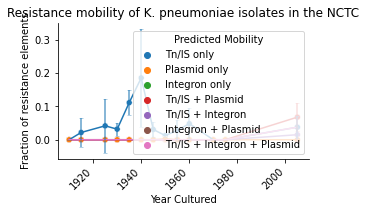

In [11]:
import pandas as pd
import seaborn as sns

kleb_df = mobility_df[mobility_df["Species_Name"] == "K. pneumoniae"].copy()

# Bin the 'Year_Cultured' column by 5-year intervals
kleb_df["Year_Cultured_Binned"] = pd.cut(
    kleb_df["Year_Cultured"], bins=range(1910, 2025, 5), labels=range(1910, 2020, 5)
)


# Group the dataframe by 'Year_Cultured_Binned' and 'Mobile' columns, and count the number of occurrences of each 'Mobile' class per year
grouped_df = (
    kleb_df.groupby(["Year_Cultured_Binned", "Mobile"]).size().reset_index(name="count")
)

# Calculate the total count of resistance elements per year
year_counts = (
    grouped_df.groupby("Year_Cultured_Binned")["count"]
    .sum()
    .reset_index(name="total_count")
)

# Merge the grouped dataframe with the year_counts dataframe to compute the fraction of resistance elements of each 'Mobile' class over time
merged_df = pd.merge(grouped_df, year_counts, on="Year_Cultured_Binned")
merged_df["fraction"] = merged_df["count"] / merged_df["total_count"]

plt.figure(figsize=(12, 6))

merged_df.loc[
    merged_df["Mobile"] == "no-me|no-integron|Plasmid-associated", "Mobile"
] = "Plasmid only"
merged_df.loc[
    merged_df["Mobile"] == "no-me|Integron-associated|no-plasmid", "Mobile"
] = "Integron only"
merged_df.loc[
    merged_df["Mobile"] == "no-me|Integron-associated|Plasmid-associated", "Mobile"
] = "Integron + Plasmid"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|Integron-associated|Plasmid-associated",
    "Mobile",
] = "Tn/IS + Integron + Plasmid"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|no-integron|Plasmid-associated", "Mobile"
] = "Tn/IS + Plasmid"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|Integron-associated|no-plasmid", "Mobile"
] = "Tn/IS + Integron"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|no-integron|no-plasmid", "Mobile"
] = "Tn/IS only"

merged_df["error"] = (
    np.sqrt(
        merged_df["fraction"] * (1 - merged_df["fraction"]) / merged_df["total_count"]
    )
    * 1.96
)


# Plot the results using a barplot in Seaborn
# sns.barplot(
#     x="Year_Cultured_Binned",
#     y="fraction",
#     hue="Mobile",
#     # errorbar='sd',
#     data=merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"],
# )
# xdf["error"] = np.sqrt(xdf["frac"] * (1 - xdf["frac"]) / xdf["all"])
# xdf["se"] = 1.96 * xdf["error"]

filtered_df = (
    merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"]
    .reset_index()
    .copy()
)

# Plot the results using a pointplot in Seaborn
# Plot the results using a pointplot in Seaborn
ax = sns.scatterplot(
    x="Year_Cultured_Binned",
    y="fraction",
    hue="Mobile",
    data=filtered_df,
    # dodge=True,
    # markers="o",
    # linestyles="-",
    hue_order=[
        "Tn/IS only",
        "Plasmid only",
        "Integron only",
        "Tn/IS + Plasmid",
        "Tn/IS + Integron",
        "Integron + Plasmid",
        "Tn/IS + Integron + Plasmid",
    ],
    # errorbar='sd'
    # multiple="stack"
)

# ax.set(ylim=(-0.005, max(filtered_df['fraction']*1.5)))

legend_handles, legend_labels = ax.get_legend_handles_labels()
hue_colors = {
    label: handle.get_facecolor()
    for handle, label in zip(legend_handles, legend_labels)
}
# print(hue_colors)

sns.lineplot(
    x="Year_Cultured_Binned",
    y="fraction",
    hue="Mobile",
    data=filtered_df,
    # dodge=True,
    # markers="o",
    # linestyles="-",
    hue_order=[
        "Tn/IS only",
        "Plasmid only",
        "Integron only",
        "Tn/IS + Plasmid",
        "Tn/IS + Integron",
        "Integron + Plasmid",
        "Tn/IS + Integron + Plasmid",
    ],
    legend=False
    # errorbar='sd'
    # multiple="stack"
)


ax.legend(title="Predicted Mobility")
ax.set(
    xlabel="Year Cultured",
    ylabel="Fraction of resistance elements",
    title="Resistance mobility of K. pneumoniae isolates in the NCTC",
)
plt.xticks(rotation=45, ha="right")

sns.despine()

# Add error bars using matplotlib
for i in range(len(filtered_df)):
    x = filtered_df.loc[i, "Year_Cultured_Binned"]
    y = filtered_df.loc[i, "fraction"]
    errord = filtered_df.loc[i, "error"]
    ax.errorbar(
        x,
        y,
        yerr=errord,
        color=hue_colors[filtered_df.loc[i, "Mobile"]],
        alpha=0.7,
        capsize=2,
        capthick=0.5,
    )

plt.gcf().set_size_inches(4.5, 2.5)
plt.savefig(
    "./figs/fig5/kleb-fractionmobileresistanceelements-point.svg",
    bbox_inches="tight",
    dpi=300,
)

plt.show()

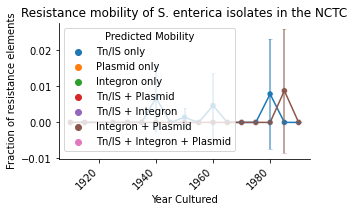

In [12]:
import pandas as pd
import seaborn as sns

salm_df = mobility_df[mobility_df["Species_Name"] == "S. enterica"].copy()

# Bin the 'Year_Cultured' column by 5-year intervals
salm_df["Year_Cultured_Binned"] = pd.cut(
    salm_df["Year_Cultured"], bins=range(1910, 2025, 5), labels=range(1910, 2020, 5)
)


# Group the dataframe by 'Year_Cultured_Binned' and 'Mobile' columns, and count the number of occurrences of each 'Mobile' class per year
grouped_df = (
    salm_df.groupby(["Year_Cultured_Binned", "Mobile"]).size().reset_index(name="count")
)

# Calculate the total count of resistance elements per year
year_counts = (
    grouped_df.groupby("Year_Cultured_Binned")["count"]
    .sum()
    .reset_index(name="total_count")
)

# Merge the grouped dataframe with the year_counts dataframe to compute the fraction of resistance elements of each 'Mobile' class over time
merged_df = pd.merge(grouped_df, year_counts, on="Year_Cultured_Binned")
merged_df["fraction"] = merged_df["count"] / merged_df["total_count"]

plt.figure(figsize=(12, 6))

merged_df.loc[
    merged_df["Mobile"] == "no-me|no-integron|Plasmid-associated", "Mobile"
] = "Plasmid only"
merged_df.loc[
    merged_df["Mobile"] == "no-me|Integron-associated|no-plasmid", "Mobile"
] = "Integron only"
merged_df.loc[
    merged_df["Mobile"] == "no-me|Integron-associated|Plasmid-associated", "Mobile"
] = "Integron + Plasmid"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|Integron-associated|Plasmid-associated",
    "Mobile",
] = "Tn/IS + Integron + Plasmid"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|no-integron|Plasmid-associated", "Mobile"
] = "Tn/IS + Plasmid"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|Integron-associated|no-plasmid", "Mobile"
] = "Tn/IS + Integron"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|no-integron|no-plasmid", "Mobile"
] = "Tn/IS only"

merged_df["error"] = (
    np.sqrt(
        merged_df["fraction"] * (1 - merged_df["fraction"]) / merged_df["total_count"]
    )
    * 1.96
)


# Plot the results using a barplot in Seaborn
# sns.barplot(
#     x="Year_Cultured_Binned",
#     y="fraction",
#     hue="Mobile",
#     # errorbar='sd',
#     data=merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"],
# )
# xdf["error"] = np.sqrt(xdf["frac"] * (1 - xdf["frac"]) / xdf["all"])
# xdf["se"] = 1.96 * xdf["error"]

filtered_df = (
    merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"]
    .reset_index()
    .copy()
)

# Plot the results using a pointplot in Seaborn
# Plot the results using a pointplot in Seaborn
ax = sns.scatterplot(
    x="Year_Cultured_Binned",
    y="fraction",
    hue="Mobile",
    data=filtered_df,
    # dodge=True,
    # markers="o",
    # linestyles="-",
    hue_order=[
        "Tn/IS only",
        "Plasmid only",
        "Integron only",
        "Tn/IS + Plasmid",
        "Tn/IS + Integron",
        "Integron + Plasmid",
        "Tn/IS + Integron + Plasmid",
    ],
    # errorbar='sd'
    # multiple="stack"
)

# ax.set(ylim=(-0.005, max(filtered_df['fraction']*1.5)))

legend_handles, legend_labels = ax.get_legend_handles_labels()
hue_colors = {
    label: handle.get_facecolor()
    for handle, label in zip(legend_handles, legend_labels)
}
# print(hue_colors)

sns.lineplot(
    x="Year_Cultured_Binned",
    y="fraction",
    hue="Mobile",
    data=filtered_df,
    # dodge=True,
    # markers="o",
    # linestyles="-",
    hue_order=[
        "Tn/IS only",
        "Plasmid only",
        "Integron only",
        "Tn/IS + Plasmid",
        "Tn/IS + Integron",
        "Integron + Plasmid",
        "Tn/IS + Integron + Plasmid",
    ],
    legend=False
    # errorbar='sd'
    # multiple="stack"
)


ax.legend(title="Predicted Mobility")
ax.set(
    xlabel="Year Cultured",
    ylabel="Fraction of resistance elements",
    title="Resistance mobility of S. enterica isolates in the NCTC",
)
plt.xticks(rotation=45, ha="right")

sns.despine()

# Add error bars using matplotlib
for i in range(len(filtered_df)):
    x = filtered_df.loc[i, "Year_Cultured_Binned"]
    y = filtered_df.loc[i, "fraction"]
    errord = filtered_df.loc[i, "error"]
    ax.errorbar(
        x,
        y,
        yerr=errord,
        color=hue_colors[filtered_df.loc[i, "Mobile"]],
        alpha=0.7,
        capsize=2,
        capthick=0.5,
    )

plt.gcf().set_size_inches(4.5, 2.5)
plt.savefig(
    "./figs/fig5/salm-fractionmobileresistanceelements-point.svg",
    bbox_inches="tight",
    dpi=300,
)

plt.show()

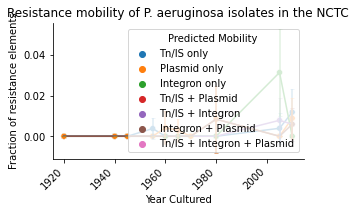

In [13]:
pseud_df = mobility_df[mobility_df["Species_Name"] == "P. aeruginosa"].copy()

# Bin the 'Year_Cultured' column by 5-year intervals
pseud_df["Year_Cultured_Binned"] = pd.cut(
    pseud_df["Year_Cultured"], bins=range(1910, 2025, 5), labels=range(1910, 2020, 5)
)


# Group the dataframe by 'Year_Cultured_Binned' and 'Mobile' columns, and count the number of occurrences of each 'Mobile' class per year
grouped_df = (
    pseud_df.groupby(["Year_Cultured_Binned", "Mobile"])
    .size()
    .reset_index(name="count")
)

# Calculate the total count of resistance elements per year
year_counts = (
    grouped_df.groupby("Year_Cultured_Binned")["count"]
    .sum()
    .reset_index(name="total_count")
)

# Merge the grouped dataframe with the year_counts dataframe to compute the fraction of resistance elements of each 'Mobile' class over time
merged_df = pd.merge(grouped_df, year_counts, on="Year_Cultured_Binned")
merged_df["fraction"] = merged_df["count"] / merged_df["total_count"]

plt.figure(figsize=(12, 6))

merged_df.loc[
    merged_df["Mobile"] == "no-me|no-integron|Plasmid-associated", "Mobile"
] = "Plasmid only"
merged_df.loc[
    merged_df["Mobile"] == "no-me|Integron-associated|no-plasmid", "Mobile"
] = "Integron only"
merged_df.loc[
    merged_df["Mobile"] == "no-me|Integron-associated|Plasmid-associated", "Mobile"
] = "Integron + Plasmid"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|Integron-associated|Plasmid-associated",
    "Mobile",
] = "Tn/IS + Integron + Plasmid"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|no-integron|Plasmid-associated", "Mobile"
] = "Tn/IS + Plasmid"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|Integron-associated|no-plasmid", "Mobile"
] = "Tn/IS + Integron"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|no-integron|no-plasmid", "Mobile"
] = "Tn/IS only"

merged_df["error"] = (
    np.sqrt(
        merged_df["fraction"] * (1 - merged_df["fraction"]) / merged_df["total_count"]
    )
    * 1.96
)


# Plot the results using a barplot in Seaborn
# sns.barplot(
#     x="Year_Cultured_Binned",
#     y="fraction",
#     hue="Mobile",
#     # errorbar='sd',
#     data=merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"],
# )
# xdf["error"] = np.sqrt(xdf["frac"] * (1 - xdf["frac"]) / xdf["all"])
# xdf["se"] = 1.96 * xdf["error"]

filtered_df = (
    merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"]
    .reset_index()
    .copy()
)

# Plot the results using a pointplot in Seaborn
# Plot the results using a pointplot in Seaborn
ax = sns.scatterplot(
    x="Year_Cultured_Binned",
    y="fraction",
    hue="Mobile",
    data=filtered_df,
    # dodge=True,
    # markers="o",
    # linestyles="-",
    hue_order=[
        "Tn/IS only",
        "Plasmid only",
        "Integron only",
        "Tn/IS + Plasmid",
        "Tn/IS + Integron",
        "Integron + Plasmid",
        "Tn/IS + Integron + Plasmid",
    ],
    # errorbar='sd'
    # multiple="stack"
)

# ax.set(ylim=(-0.005, max(filtered_df['fraction']*1.5)))

legend_handles, legend_labels = ax.get_legend_handles_labels()
hue_colors = {
    label: handle.get_facecolor()
    for handle, label in zip(legend_handles, legend_labels)
}
# print(hue_colors)

sns.lineplot(
    x="Year_Cultured_Binned",
    y="fraction",
    hue="Mobile",
    data=filtered_df,
    # dodge=True,
    # markers="o",
    # linestyles="-",
    hue_order=[
        "Tn/IS only",
        "Plasmid only",
        "Integron only",
        "Tn/IS + Plasmid",
        "Tn/IS + Integron",
        "Integron + Plasmid",
        "Tn/IS + Integron + Plasmid",
    ],
    legend=False
    # errorbar='sd'
    # multiple="stack"
)


ax.legend(title="Predicted Mobility")
ax.set(
    xlabel="Year Cultured",
    ylabel="Fraction of resistance elements",
    title="Resistance mobility of P. aeruginosa isolates in the NCTC",
)
plt.xticks(rotation=45, ha="right")

sns.despine()

# Add error bars using matplotlib
for i in range(len(filtered_df)):
    x = filtered_df.loc[i, "Year_Cultured_Binned"]
    y = filtered_df.loc[i, "fraction"]
    errord = filtered_df.loc[i, "error"]
    ax.errorbar(
        x,
        y,
        yerr=errord,
        color=hue_colors[filtered_df.loc[i, "Mobile"]],
        alpha=0.7,
        capsize=2,
        capthick=0.5,
    )

plt.gcf().set_size_inches(4.5, 2.5)
plt.savefig(
    "./figs/fig5/pseud-fractionmobileresistanceelements-point.svg",
    bbox_inches="tight",
    dpi=300,
)

plt.show()

In [14]:
staph_df = mobility_df[mobility_df["Species_Name"] == "S. aureus"].copy()

# Bin the 'Year_Cultured' column by 5-year intervals
staph_df["Year_Cultured_Binned"] = pd.cut(
    staph_df["Year_Cultured"], bins=range(1910, 2025, 5), labels=range(1910, 2020, 5)
)

# print(staph_df['Mobile'].value_counts())

# Group the dataframe by 'Year_Cultured_Binned' and 'Mobile' columns, and count the number of occurrences of each 'Mobile' class per year
grouped_df = (
    staph_df.groupby(["Year_Cultured_Binned", "Mobile"])
    .size()
    .reset_index(name="count")
)

# print(grouped_df['count'].value_counts())

# Calculate the total count of resistance elements per year
year_counts = (
    grouped_df.groupby("Year_Cultured_Binned")["count"]
    .sum()
    .reset_index(name="total_count")
)
# print(year_counts)

# Merge the grouped dataframe with the year_counts dataframe to compute the fraction of resistance elements of each 'Mobile' class over time
merged_df = pd.merge(grouped_df, year_counts, on="Year_Cultured_Binned")
# print(merged_df['fraction'].value_counts())
merged_df["fraction"] = merged_df["count"] / merged_df["total_count"]

plt.figure(figsize=(12, 6))

merged_df.loc[
    merged_df["Mobile"] == "no-me|no-integron|Plasmid-associated", "Mobile"
] = "Plasmid only"
merged_df.loc[
    merged_df["Mobile"] == "no-me|Integron-associated|no-plasmid", "Mobile"
] = "Integron only"
merged_df.loc[
    merged_df["Mobile"] == "no-me|Integron-associated|Plasmid-associated", "Mobile"
] = "Integron + Plasmid"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|Integron-associated|Plasmid-associated",
    "Mobile",
] = "Tn/IS + Integron + Plasmid"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|no-integron|Plasmid-associated", "Mobile"
] = "Tn/IS + Plasmid"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|Integron-associated|no-plasmid", "Mobile"
] = "Tn/IS + Integron"
merged_df.loc[
    merged_df["Mobile"] == "mobileelement|no-integron|no-plasmid", "Mobile"
] = "Tn/IS only"

merged_df["error"] = (
    np.sqrt(
        merged_df["fraction"] * (1 - merged_df["fraction"]) / merged_df["total_count"]
    )
    * 1.96
)


# Plot the results using a barplot in Seaborn
# sns.barplot(
#     x="Year_Cultured_Binned",
#     y="fraction",
#     hue="Mobile",
#     # errorbar='sd',
#     data=merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"],
# )
# xdf["error"] = np.sqrt(xdf["frac"] * (1 - xdf["frac"]) / xdf["all"])
# xdf["se"] = 1.96 * xdf["error"]

filtered_df = merged_df.reset_index().copy()
# print(filtered_df)

# Plot the results using a pointplot in Seaborn
# Plot the results using a pointplot in Seaborn
ax = sns.scatterplot(
    x="Year_Cultured_Binned",
    y="fraction",
    hue="Mobile",
    data=filtered_df.loc[,
    # dodge=True,
    # markers="o",
    # linestyles="-",
    hue_order=[
        "Tn/IS only",
        "Plasmid only",
        "Integron only",
        "Tn/IS + Plasmid",
        "Tn/IS + Integron",
        "Integron + Plasmid",
        "Tn/IS + Integron + Plasmid",
    ],
    # errorbar='sd'
    # multiple="stack"
)

# ax.set(ylim=(-0.005, max(filtered_df['fraction']*1.5)))

legend_handles, legend_labels = ax.get_legend_handles_labels()
hue_colors = {label: handle.get_facecolor() for handle, label in zip(legend_handles, legend_labels)}
# print(hue_colors)

sns.lineplot(
    x="Year_Cultured_Binned",
    y="fraction",
    hue="Mobile",
    data=filtered_df,
    # dodge=True,
    # markers="o",
    # linestyles="-",
    hue_order=[
        "Tn/IS only",
        "Plasmid only",
        "Integron only",
        "Tn/IS + Plasmid",
        "Tn/IS + Integron",
        "Integron + Plasmid",
        "Tn/IS + Integron + Plasmid",
    ],
    legend=False
    # errorbar='sd'
    # multiple="stack"
)


ax.legend(title="Predicted Mobility")
ax.set(
    xlabel="Year Cultured",
    ylabel="Fraction of resistance elements",
    title="Resistance mobility of S. aureus isolates in the NCTC",
)
plt.xticks(rotation=45, ha="right")

sns.despine()

# Add error bars using matplotlib
for i in range(len(filtered_df)):
    x = filtered_df.loc[i, 'Year_Cultured_Binned']
    y = filtered_df.loc[i, 'fraction']
    errord = filtered_df.loc[i, 'error']
    ax.errorbar(x, y, yerr=errord, color=hue_colors[filtered_df.loc[i, 'Mobile']], alpha=0.7, capsize=2, capthick=0.5)
    
plt.gcf().set_size_inches(4.5, 2.5)
plt.savefig(
    "./figs/fig5/staph-fractionmobileresistanceelements-point.svg",
    bbox_inches="tight",
    dpi=300,
)

plt.show()

SyntaxError: invalid syntax (771158901.py, line 85)

In [ ]:
merged_mobtyper = pd.read_csv(
    "/n/data1/hms/dbmi/baym/arya/projects/project_microtrawler/data/3_analysis-plasmid/merged-mobtyper",
    sep="\t",
)
merged_mobtyper.rename(
    columns={"AccNum": "Accession_Number", "predicted_mobility": "Predicted Mobility"},
    inplace=True,
)
merged_mobtyper["Year_Cultured"] = merged_mobtyper["Accession_Number"].map(year_dict)
# merged_mobtyper

merged_mobtyper["Predicted Mobility"] = merged_mobtyper[
    "Predicted Mobility"
].str.title()

sns.set_theme(font="Arial", style="white", font_scale=0.7)
sns.set_palette("deep")
histogram = sns.histplot(
    data=merged_mobtyper,
    x="Year_Cultured",
    hue="Predicted Mobility",
    # multiple="stack",
    cumulative=True,
    fill=False,
    element="step",
    legend="full",
)
histogram.set(xlabel="Year Cultured", title="All NCTC plasmids over time")

figure = plt.gcf()  # get current figure
sns.despine()
figure.set_size_inches(3.5, 2.5)
plt.savefig("./figs/fig5/plasmids-overtime.svg", dpi=300, bbox_inches="tight")

In [ ]:
merged_mobtyper

In [ ]:
merged_contigreport = pd.read_csv(
    "/n/data1/hms/dbmi/baym/arya/projects/project_microtrawler/data/3_analysis-plasmid/merged-contigreport",
    sep="\t",
)
merged_contigreport.rename(
    columns={"AccNum": "Accession_Number"},
    inplace=True,
)
merged_contigreport["Year_Cultured"] = merged_contigreport["Accession_Number"].map(
    year_dict
)
merged_contigreport["Contig"] = merged_contigreport["contig_id"].str.split(
    " ", expand=True
)[0]
merged_contigreport

In [ ]:
plasmidcontigs_rgidf_merged = df.merge(
    merged_contigreport,
    on=["Accession_Number", "Contig", "Year_Cultured"],
    how="outer",
    indicator=True,
)

plasmidcontigs_rgidf_merged = plasmidcontigs_rgidf_merged[
    (plasmidcontigs_rgidf_merged["_merge"] == "right_only")
    | (plasmidcontigs_rgidf_merged["_merge"] == "both")
]

plasmids_contigstuff = plasmidcontigs_rgidf_merged[
    [
        "Contig",
        "Year_Cultured",
        "Resistance Mechanism",
        "Best_Hit_ARO",
        "AMR Gene Family",
    ]
].drop_duplicates("Contig")

plasmids_contigstuff["Resistance"] = "yes"
plasmids_contigstuff.loc[
    plasmids_contigstuff["Resistance Mechanism"].isna(), "Resistance"
] = "no"
plasmids_contigstuff

In [ ]:
predictedmobility_contig = merged_mobtyper.merge(
    merged_contigreport,
    how="outer",
    indicator=True,
    on=["Accession_Number", "primary_cluster_id"],
)[["Contig", "Predicted mobility"]]

contig_mobilitydict = predictedmobility_contig.set_index("Contig").to_dict()[
    "Predicted mobility"
]
contig_mobilitydict

plasmids_contigstuff["Predicted mobility"] = plasmids_contigstuff["Contig"].map(
    contig_mobilitydict
)

In [ ]:
from scipy.stats import binom


def get_frac_df(dataframe, value, column, sums=False, verbose=False):
    num_yearcultured_allstrains_dict = (
        dataframe.drop_duplicates(subset=["Contig"])["Year_Cultured"]
        .value_counts()
        .to_dict()
    )
    num_yearcultured_valposstrains_dict = (
        dataframe.loc[dataframe[column].str.contains(value, na=False, regex=True)]
        .drop_duplicates(subset=["Contig"])["Year_Cultured"]
        .value_counts()
        .to_dict()
    )
    fractional_dictionary = {}
    for years in num_yearcultured_allstrains_dict:
        if num_yearcultured_allstrains_dict[years] == 0:
            continue
        if years in num_yearcultured_valposstrains_dict:
            val = [
                num_yearcultured_valposstrains_dict[years],
                num_yearcultured_allstrains_dict[years],
            ]
            # fraction = (
            #     num_yearcultured_valposstrains_dict[years]
            #     / num_yearcultured_allstrains_dict[years]
            # )
        else:
            val = [0, num_yearcultured_allstrains_dict[years]]
        fractional_dictionary[years] = val

    yeardf = (
        pd.DataFrame.from_dict(
            fractional_dictionary, orient="index", columns=["num_pos", "all"]
        )
        .reset_index()
        .rename(columns={"index": "year"})
        .sort_values(by="year")
        .reset_index(drop=True)
    )
    yeardf["frac"] = yeardf["num_pos"] / yeardf["all"]
    if verbose:
        print(yeardf)
    return yeardf


def plot_mobile_frac_error(
    df,
    ex,
    fig=None,
    ax=None,
    verbose=True,
    sims=100,
    figname="doodoo",
    savefig=False,
    smooth=3,
    col="Drug Class",
    value="phenotype",
):

    sns.set_theme(font="Arial", style="white", font_scale=0.7)

    frac_df = get_frac_df(df, ex, col, verbose)

    # plt.figure(figsize=(14, 8))

    d = {"Year": [], "num_pos": [], "all": []}
    for years in range(frac_df["year"].min(), frac_df["year"].max()):
        upb = smooth + years
        downb = years - smooth
        g = frac_df.loc[(frac_df["year"] <= upb) & (downb <= frac_df["year"])]
        d["Year"].append(years)
        # if years >= year:
        # d["Anthropogenicity"].append("Post-Human")
        # else:
        # d["Anthropogenicity"].append("Pre-Human")
        d["num_pos"].append(g["num_pos"].sum())
        d["all"].append(g["all"].sum())
        # print(d)
        # d["frac"].append(d['num_pos'][0]/d['all'][0])
    xdf = pd.DataFrame(data=d)
    xdf["frac"] = xdf["num_pos"] / xdf["all"]
    xdf["error"] = np.sqrt(xdf["frac"] * (1 - xdf["frac"]) / xdf["all"])
    xdf["se"] = 1.96 * xdf["error"]
    xdf["ci_high"], xdf["ci_high"] = binom.interval(0.95, xdf["all"], xdf["frac"])
    # print(xdf)

    # make subplots for the figure
    if fig == None and ax == None:
        fig1, ax1 = plt.subplots(figsize=(14, 8))
    else:
        ax1 = ax
        fig1 = fig

    ax1.set(xlabel="Year Cultured")

    lp = sns.lineplot(
        data=xdf,
        x="Year",
        y="frac",
        markers=True,
        # color=sns.color_palette("deep")[0],
        ax=ax1,
    )
    lp.set(ylim=(0, 0.6))
    dp = sns.scatterplot(
        data=xdf,
        x="Year",
        y="frac",
        legend=False,
        ax=ax1,
    )
    colors = [artist.get_facecolor() for artist in dp.collections]
    # print(colors)
    ax1.errorbar(
        xdf["Year"],
        xdf["frac"],
        yerr=xdf["error"] * 1.96,
        fmt="none",
        capsize=3,
        capthick=1,
        color=colors[-1][0],
        errorevery=3,
    )
    sns.despine()
    # ax1.set(ylabel="Fraction of plasmids with {}".format(value))

    return fig1, ax1
    # if savefig:
    #     plt.gcf().set_size_inches(5.0, 3)
    #     plt.savefig(
    #         "{}-histogram.svg".format(figname),
    #         bbox_inches="tight",
    #         dpi=300,
    #     )
    # plt.show()


fig, ax = plot_mobile_frac_error(
    plasmids_contigstuff,
    "yes",
    col="Resistance",
    value="≥ 1 resistance element",
    smooth=5,
)
ax.set(ylabel="Fraction of plasmids with ≥ 1 resistance element")
plt.gcf().set_size_inches(4.5, 3.5)
plt.savefig(
    "figs/fig5/fractionplasmids-with_resistance.svg", bbox_inches="tight", dpi=300
)
plt.show()

In [ ]:
fig, ax = plot_mobile_frac_error(
    plasmids_contigstuff[plasmids_contigstuff["Resistance"] == "yes"],
    "Conjugative",
    col="Predicted mobility",
    smooth=5,
)
plt.gcf().set_size_inches(4.5, 3.5)

In [ ]:
fig, ax = plot_mobile_frac_error(
    plasmids_contigstuff[plasmids_contigstuff["Resistance"] == "yes"],
    "Non-Mobilizable",
    fig=fig,
    ax=ax,
    col="Predicted mobility",
    smooth=5,
)
fig

In [ ]:
fig, ax = plot_mobile_frac_error(
    plasmids_contigstuff[plasmids_contigstuff["Resistance"] == "yes"],
    "Mobilizable",
    fig=fig,
    ax=ax,
    col="Predicted mobility",
    smooth=5,
)
fig

In [ ]:
fig

In [ ]:
plasmids_contigstuff

In [ ]:
mobtyper_rgidf_merge = merged_mobtyper.merge(
    df,
    on=["Accession_Number", "Year_Cultured"],
    how="outer",
    indicator=True,
)
mobtyper_rgidf_merge

In [ ]:
# merged_contigreport = pd.read_csv(
#     "/n/data1/hms/dbmi/baym/arya/projects/project_microtrawler/data/3_analysis-plasmid/merged-contigreport",
#     sep="\t",
# )
# merged_contigreport['Year_Cultured'] = merged_contigreport['AccNum'].map(year_dict)
# merged_contigreport

In [ ]:
from scipy.stats import binom


def get_frac_df(dataframe, value, column, sums=False, verbose=False):
    num_yearcultured_allstrains_dict = (
        dataframe.drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
        .value_counts()
        .to_dict()
    )
    num_yearcultured_valposstrains_dict = (
        dataframe.loc[dataframe[column].str.contains(value, na=False, regex=True)]
        .drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
        .value_counts()
        .to_dict()
    )
    fractional_dictionary = {}
    for years in num_yearcultured_allstrains_dict:
        if num_yearcultured_allstrains_dict[years] == 0:
            continue
        if years in num_yearcultured_valposstrains_dict:
            val = [
                num_yearcultured_valposstrains_dict[years],
                num_yearcultured_allstrains_dict[years],
            ]
            # fraction = (
            #     num_yearcultured_valposstrains_dict[years]
            #     / num_yearcultured_allstrains_dict[years]
            # )
        else:
            val = [0, num_yearcultured_allstrains_dict[years]]
        fractional_dictionary[years] = val

    yeardf = (
        pd.DataFrame.from_dict(
            fractional_dictionary, orient="index", columns=["num_pos", "all"]
        )
        .reset_index()
        .rename(columns={"index": "year"})
        .sort_values(by="year")
        .reset_index(drop=True)
    )
    yeardf["frac"] = yeardf["num_pos"] / yeardf["all"]
    if verbose:
        print(yeardf)
    return yeardf


def plot_mobile_frac_error(
    df,
    df2,
    ex,
    ex2,
    year,
    verbose=True,
    sims=100,
    figname="doodoo",
    savefig=False,
    smooth=5,
    col="Drug Class",
    col2="_merge",
    value="phenotype",
):

    sns.set_theme(font="Arial", style="white", font_scale=0.7)

    frac_df = get_frac_df(df, ex, col, verbose)

    plt.figure(figsize=(14, 8))

    d = {"Year": [], "num_pos": [], "all": []}
    for years in range(frac_df["year"].min(), frac_df["year"].max()):
        upb = smooth + years
        downb = years - smooth
        g = frac_df.loc[(frac_df["year"] <= upb) & (downb <= frac_df["year"])]
        d["Year"].append(years)
        # if years >= year:
        # d["Anthropogenicity"].append("Post-Human")
        # else:
        # d["Anthropogenicity"].append("Pre-Human")
        d["num_pos"].append(g["num_pos"].sum())
        d["all"].append(g["all"].sum())
        # print(d)
        # d["frac"].append(d['num_pos'][0]/d['all'][0])
    xdf = pd.DataFrame(data=d)
    xdf["frac"] = xdf["num_pos"] / xdf["all"]
    xdf["error"] = np.sqrt(xdf["frac"] * (1 - xdf["frac"]) / xdf["all"])
    xdf["se"] = 1.96 * xdf["error"]
    xdf["ci_high"], xdf["ci_high"] = binom.interval(0.95, xdf["all"], xdf["frac"])
    # print(xdf)

    # make subplots for the figure
    fig1, ax1 = plt.subplots(figsize=(14, 8))

    ax1.set(xlabel="Year Cultured")

    lp = sns.lineplot(
        data=xdf,
        x="Year",
        y="frac",
        markers=True,
        color=sns.color_palette("deep")[0],
        ax=ax1,
    )
    lp.set(ylim=(0, 1))
    dp = sns.scatterplot(
        data=xdf,
        x="Year",
        y="frac",
        legend=False,
        ax=ax1,
    )
    ax1.errorbar(
        xdf["Year"],
        xdf["frac"],
        yerr=xdf["error"] * 1.96,
        fmt="none",
        capsize=3,
        capthick=1,
        # color=sns.color_palette("deep")[0],
        errorevery=2,
    )
    ax1.set(ylabel="Fraction of isolates with {}".format(value))

    ax2 = ax1.twinx()
    frac_df = get_frac_df(df2, ex2, col2, verbose)

    plt.figure(figsize=(14, 8))

    d = {"Year": [], "num_pos": [], "all": []}
    for years in range(frac_df["year"].min(), frac_df["year"].max()):
        upb = smooth + years
        downb = years - smooth
        g = frac_df.loc[(frac_df["year"] <= upb) & (downb <= frac_df["year"])]
        d["Year"].append(years)
        # if years >= year:
        # d["Anthropogenicity"].append("Post-Human")
        # else:
        # d["Anthropogenicity"].append("Pre-Human")
        d["num_pos"].append(g["num_pos"].sum())
        d["all"].append(g["all"].sum())
        # print(d)
        # d["frac"].append(d['num_pos'][0]/d['all'][0])
    xdf = pd.DataFrame(data=d)
    xdf["frac"] = xdf["num_pos"] / xdf["all"]
    xdf["error"] = np.sqrt(xdf["frac"] * (1 - xdf["frac"]) / xdf["all"])
    xdf["se"] = 1.96 * xdf["error"]
    xdf["ci_high"], xdf["ci_high"] = binom.interval(0.95, xdf["all"], xdf["frac"])
    # print(xdf)
    ax1.set(xlabel="Year Cultured")

    lp = sns.lineplot(
        data=xdf,
        x="Year",
        y="frac",
        markers=True,
        color=sns.color_palette("deep")[1],
        ax=ax2,
    )
    lp.set(ylim=(0, 1))
    dp = sns.scatterplot(
        data=xdf,
        x="Year",
        y="frac",
        legend=False,
        color=sns.color_palette("deep")[1],
        ax=ax2,
    )
    ax2.errorbar(
        xdf["Year"],
        xdf["frac"],
        yerr=xdf["error"] * 1.96,
        fmt="none",
        capsize=3,
        capthick=1,
        color=sns.color_palette("deep")[1],
        errorevery=2,
    )
    ax2.set(ylabel="Fraction of plasmids with {}".format(value))

    if savefig:
        plt.gcf().set_size_inches(5.0, 3)
        plt.savefig(
            "{}-fractionofresist.svg".format(figname),
            bbox_inches="tight",
            dpi=300,
        )

    fig2, ax2 = plt.subplots(figsize=(14, 8))
    ax2.set(ylabel="Count of isolates analyzed", xlabel="Year Cultured")

    # ax2 = ax1.twinx()

    # create another copy of the dataframe
    drop_dups = df.drop_duplicates(subset=["Accession_Number"]).copy()
    # drop_dups["Anthropogenicity"] = "Post-Human"
    # print(drop_dups)

    # drop_dups.loc[drop_dups["Year_Cultured"] < year, ["Anthropogenicity"]] = "Pre-Human"
    histogram = sns.histplot(
        data=drop_dups,
        x="Year_Cultured",
        # hue="Anthropogenicity",
        # palette=[sns.color_palette("deep")[0], sns.color_palette("deep")[1]],
        ax=ax2,
        multiple="stack",
        linewidth=0.3,
    )
    # dp.axvline(year, color="red")#, label='{} introduced'.format(year))
    # plt.legend()
    # plt.text(4, 1, f'{year} introduce', ha='left', va='center')

    if savefig:
        plt.gcf().set_size_inches(5.0, 3)
        plt.savefig(
            "{}-histogram.svg".format(figname),
            bbox_inches="tight",
            dpi=300,
        )
    plt.show()

In [ ]:
merged_mobtyper

In [ ]:
allplasmids = mobtyper_rgidf_merge[mobtyper_rgidf_merge["_merge"] == "both"].copy()
# print(allplasmids.columns)
allplasmids.drop(columns=["_merge"], inplace=True)
merged2 = allplasmids.merge(
    mamodf_resistance,
    on=["Accession_Number", "Contig", "Start", "Stop"],
    how="outer",
    indicator=True,
)
merged2
# merged2['Accession_Number'] = 0
# merged2.loc[merged2['Accession_Number_x'] != np.nan, 'Accession_Number'] = e
merged2["Year_Cultured"] = merged2["Accession_Number"].map(year_dict)
# merged2['Year_Cultured']
merged2[merged2["_merge"] == "both"]

In [ ]:
mobility_df["Mobile Element Type"] = mobility_df.apply(
    lambda x: "Mobile Element"
    if x["Mobile"] == 1
    else (
        "Integron"
        if x["IntegronFinder"] != "no-integron"
        else ("Plasmid" if x["mob_recon"] != "no-plasmid" else "Not Identified")
    ),
    axis=1,
)

In [15]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(data=mobility_df, x="Mobile Element Type")
plt.title("Distribution of AMR Genes by Location")
plt.xlabel("Location")
plt.ylabel("Count")
plt.show()

ValueError: Could not interpret input 'Mobile Element Type'

<Figure size 576x432 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Calculate the number of AMR genes that are mobile per year
mobile_per_year = (
    mobility_df[mobility_df["Mobile"] == 1]
    .groupby("Year_Cultured")["Accession_Number"]
    .count()
)

# Calculate the total number of AMR genes per year
total_per_year = mobility_df.groupby("Year_Cultured")["Accession_Number"].count()

# Calculate the fraction of AMR genes that are mobile per year
fraction_per_year = mobile_per_year / total_per_year

sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.lineplot(x="Year_Cultured", y=fraction_per_year, data=mobility_df)
plt.title("Fraction of Mobile AMR Genes by Year Cultured")
plt.xlabel("Year Cultured")
plt.ylabel("Fraction of Mobile AMR Genes")
plt.show()

/home/ak586/.conda/envs/RESIST/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning:

invalid value encountered in reduce

/home/ak586/.conda/envs/RESIST/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning:

invalid value encountered in reduce

/home/ak586/.conda/envs/RESIST/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning:

invalid value encountered in reduce

/home/ak586/.conda/envs/RESIST/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning:

invalid value encountered in reduce



<Figure size 1008x576 with 0 Axes>

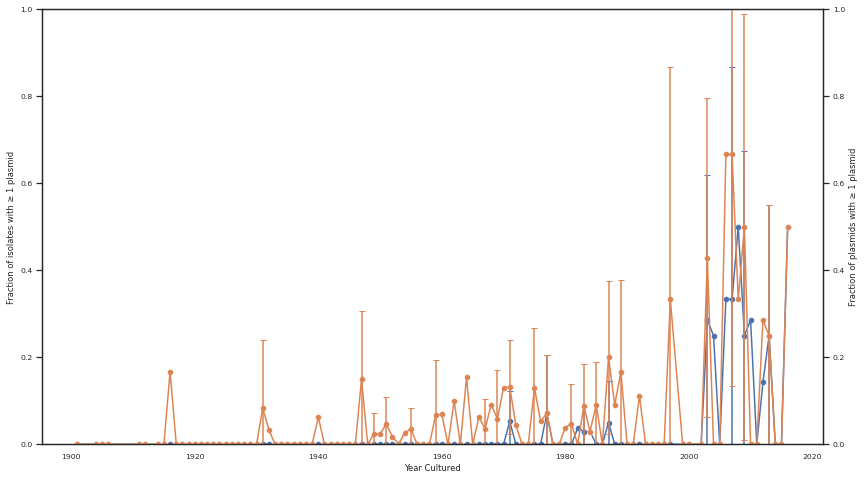

<Figure size 1008x576 with 0 Axes>

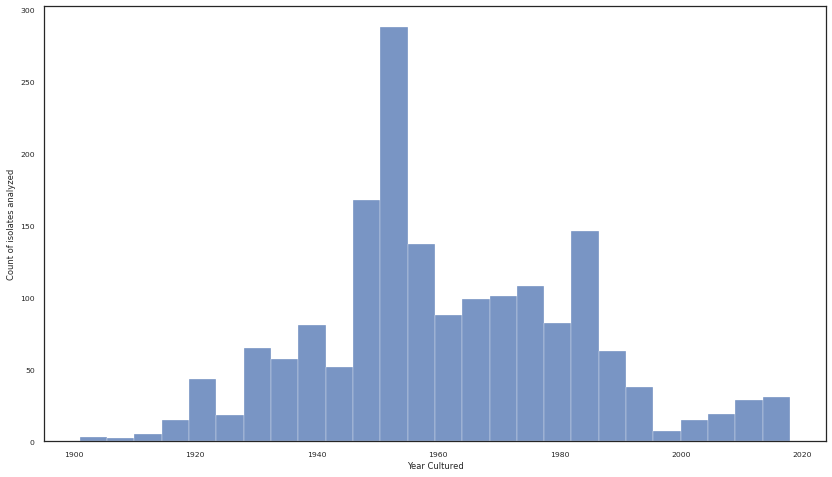

In [30]:
plot_mobile_frac_error(
    df=mobility_df,
    df2=mobility_df,
    ex="complete|CALIN",
    ex2="plasmid-contig",
    year=1943,
    sims=5,
    verbose=False,
    col="IntegronFinder",
    col2="mob_recon",
    value="≥ 1 plasmid",
    savefig=False,
    smooth=0,
    figname="./figs/fig5/all-plasmid",
)

In [31]:
merged2[merged2["_merge"] == "both"]

,Accession_Number,sample_id,num_contigs,size,gc,md5,rep_type(s),rep_type_accession(s),relaxase_type(s),relaxase_type_accession(s),...,Note,Species,Subspecies,Species_Name,AbG,mobileelementfinder,IntegronFinder,PlasmidFinder,mob_recon,_merge
2,NCTC10006,assembly_10:AH399,1.0,2105.0,38.194774,1153df154e83eefd927594fe09f76be2,-,-,-,-,...,Null,Klebsiella aerogenes,Null,K. aerogenes,adeF,no-me,no-integron,no-plasmid,no-plasmid,both
3,NCTC10006,assembly_12:AH177,1.0,6249.0,43.815010,add2ec8852dcb0977dd496ce6156fb94,-,-,-,-,...,Null,Klebsiella aerogenes,Null,K. aerogenes,adeF,no-me,no-integron,no-plasmid,no-plasmid,both
4,NCTC10006,assembly_7:AG790,1.0,7647.0,36.811822,fb84cf4d2241d3964f865d74f25455f6,-,-,-,-,...,Null,Klebsiella aerogenes,Null,K. aerogenes,adeF,no-me,no-integron,no-plasmid,no-plasmid,both
5,NCTC10006,assembly_8:AG912,1.0,4282.0,38.019617,c6599b85c96949b588a0c6a38338d2c5,-,-,-,-,...,Null,Klebsiella aerogenes,Null,K. aerogenes,adeF,no-me,no-integron,no-plasmid,no-plasmid,both
6,NCTC10006,assembly_9:AH251,1.0,2323.0,35.600517,1981b166c675d17072dbf8b2c66ff60f,-,-,-,-,...,Null,Klebsiella aerogenes,Null,K. aerogenes,adeF,no-me,no-integron,no-plasmid,no-plasmid,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30449,NCTC9997,assembly_2:AA822,1.0,276068.0,51.627135,f82ada894623da577c58b3e1db507260,"IncFIB,IncFII","000107__CP014778_00094,000127__CP009275",MOBF,CP026276_00127,...,Null,Klebsiella aerogenes,Null,K. aerogenes,Escherichia coli EF-Tu mutants conferring resi...,no-me,no-integron,no-plasmid,no-plasmid,both
30450,NCTC9997,assembly_2:AA822,1.0,276068.0,51.627135,f82ada894623da577c58b3e1db507260,"IncFIB,IncFII","000107__CP014778_00094,000127__CP009275",MOBF,CP026276_00127,...,Null,Klebsiella aerogenes,Null,K. aerogenes,Haemophilus influenzae PBP3 conferring resista...,no-me,no-integron,no-plasmid,no-plasmid,both
30451,NCTC9997,assembly_2:AA822,1.0,276068.0,51.627135,f82ada894623da577c58b3e1db507260,"IncFIB,IncFII","000107__CP014778_00094,000127__CP009275",MOBF,CP026276_00127,...,Null,Klebsiella aerogenes,Null,K. aerogenes,Escherichia coli EF-Tu mutants conferring resi...,no-me,no-integron,no-plasmid,no-plasmid,both
30452,NCTC9997,assembly_2:AA822,1.0,276068.0,51.627135,f82ada894623da577c58b3e1db507260,"IncFIB,IncFII","000107__CP014778_00094,000127__CP009275",MOBF,CP026276_00127,...,Null,Klebsiella aerogenes,Null,K. aerogenes,Escherichia coli AcrAB-TolC with MarR mutation...,no-me,no-integron,no-plasmid,no-plasmid,both


In [32]:
allplasmids = mobtyper_rgidf_merge[mobtyper_rgidf_merge["_merge"] == "both"].copy()
# print(allplasmids.columns)
allplasmids.drop(columns=["_merge"], inplace=True)
merged2 = allplasmids.merge(
    mamodf_resistance,
    on=["Contig", "Start", "Stop"],
    how="outer",
    indicator=True,
).merge(mamodf_resistance)
merged2["Year_Cultured"]

0        1958.0
1        1958.0
2        1958.0
3        1958.0
4        1958.0
          ...  
43159       NaN
43160       NaN
43161       NaN
43162       NaN
43163       NaN
Name: Year_Cultured, Length: 43164, dtype: float64